Using the old model prior to meeting to verify the recreation of the results.

In [274]:
import sys
sys.path.append("..")
import importlib
import numpy as np
import matplotlib.pyplot as plt
import qutip

import system.experimental_august as system
importlib.reload(system)
import utils.solver as solver
importlib.reload(solver)
import pulse.tukey as pulse_gen
importlib.reload(pulse_gen)
import utils.expectation_values as expect
importlib.reload(expect)

pass

In [275]:
print("standard form")
print( (system.energies[1] - system.energies[0]) / (2*np.pi))
print( (system.energies[2] - system.energies[1]) / (2*np.pi))
print( (system.energies[1] - system.energies[0]) / (2*np.pi) - (system.energies[2] - system.energies[1]) / (2*np.pi))
print(system.anharm / (2*np.pi))
print()

print("full cosine recovery")
print( (system.full_cosine_energies[1] - system.full_cosine_energies[0]) / (2*np.pi))
print( (system.full_cosine_energies[2] - system.full_cosine_energies[1]) / (2*np.pi))
print( (system.full_cosine_energies[1] - system.full_cosine_energies[0]) / (2*np.pi) - (system.full_cosine_energies[2] - system.full_cosine_energies[1]) / (2*np.pi))
print(system.anharm / (2*np.pi))
print()

print("hatlab form")
print( (system.hatlab_energies[1] - system.hatlab_energies[0]) / (2*np.pi))
print( (system.hatlab_energies[2] - system.hatlab_energies[1]) / (2*np.pi))
print( (system.hatlab_energies[1] - system.hatlab_energies[0]) / (2*np.pi) - (system.hatlab_energies[2] - system.hatlab_energies[1]) / (2*np.pi))
print(system.anharm / (2*np.pi))
print()

standard form
3.76364
3.556110000000001
0.20752999999999888
-0.20752999999999996

full cosine recovery
3.9152475501511677
3.343667544848524
0.5715800053026436
-0.20752999999999996

hatlab form
3.5615475537165886
2.148844166210125
1.4127033875064634
-0.20752999999999996



drive_frequency 7.580344823171126


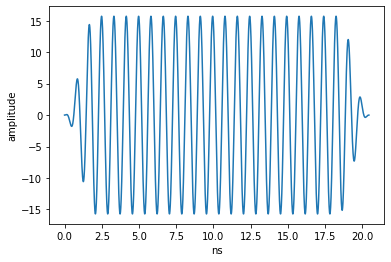

In [325]:
offset = 0.30220436
drive_frequency = (system.first_energy_spacing/3 - offset)
tlist = np.linspace(0, 20.44169987, 10000)
print("drive_frequency", drive_frequency)
pulse_gen.setup(amplitude=2.5*2*np.pi, drive_frequency= drive_frequency, ramp_coef=0.2, tlist=tlist)
plt.plot(tlist, pulse_gen.get_pulse(tlist))
plt.xlabel("ns")
plt.ylabel("amplitude")
# plt.text(0, -25, r'Flat top pulse, ramp coefficient of 0.2', fontsize=16)
plt.show()

In [326]:
# tlist = np.linspace(0, 1000, 1000*10)
# solution = solver.time_evolve(H_d=system.H0, H_c=system.H1, pertubation_func=pulse_gen.pulse_func, tlist=tlist, starting_state=system.basis_states[0], pbar=True)

solution = solver.time_evolve(H_d=system.H0, H_c=system.H1, pertubation_func=pulse_gen.pulse_func, tlist=tlist, starting_state=(system.basis_states[0]), pbar=False)
expectation_values = expect.get_all_expectation_values(solution.states, system.basis_states)


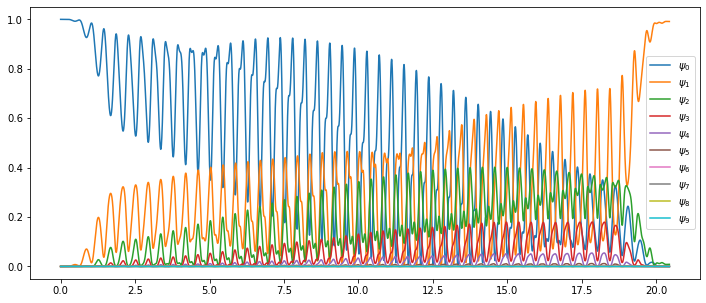

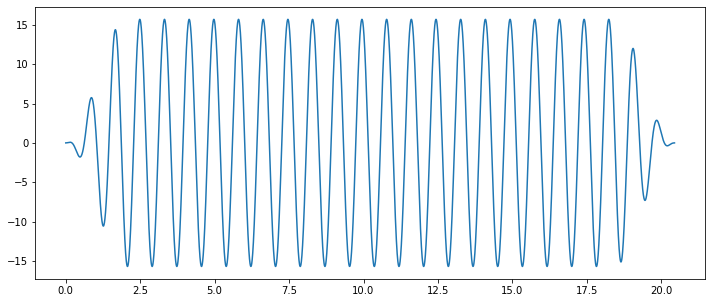

In [327]:
expectation_values = expect.get_all_expectation_values(solution.states, system.basis_states)
fig, ax = plt.subplots(figsize=(12, 5))
for i in range(0, len(expectation_values)):
    ax.plot(tlist, expectation_values[i], label="$\psi_{%i}$" % i)
plt.legend()
fig, ax = plt.subplots(figsize=(12, 5))
ax.plot(tlist, pulse_gen.get_pulse(tlist))

/var/folders/8w/jht5wjcd4kl492xz8hs9lft40000gn/T/ipykernel_27067/724180425.py:24: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = Axes3D(fig, azim=-40, elev=30)


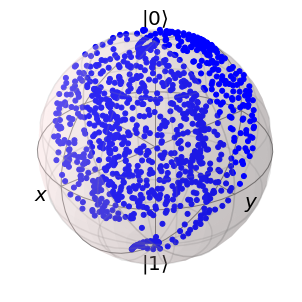

<Figure size 360x360 with 0 Axes>

In [330]:
from qutip import Bloch as bloch
from qutip import ket as ket
from qutip import Qobj

computational_subspace_kets = []
for i in range(0, len(solution.states), 10):
    computational_subspace_ket = [[solution.states[i][0][0][0]], [solution.states[i][1][0][0]]]
    computational_subspace_kets.append(Qobj(computational_subspace_ket))

xs = []
ys = []
zs = []
vecs = []
for ket in computational_subspace_kets:
    xs.append(qutip.expect(qutip.ket2dm(ket), sigmax()))
    ys.append(qutip.expect(qutip.ket2dm(ket), sigmay()))
    zs.append(qutip.expect(qutip.ket2dm(ket), sigmaz()))
    vecs.append([xs[-1], ys[-1], zs[-1]])

from matplotlib import pyplot, animation
from mpl_toolkits.mplot3d import Axes3D

fig = pyplot.figure()
ax = Axes3D(fig, azim=-40, elev=30)
sphere = bloch(axes=ax)

def animate(i):
   sphere.clear()
   sphere.add_points([xs[:i+1], ys[:i+1], zs[:i+1]])
   sphere.make_sphere()
   return ax

def init():
   sphere.vector_color = ['r']
   return ax

ani = animation.FuncAnimation(fig, animate, np.arange(len(xs)),
                              init_func=init, blit=False, repeat=False)

ani.save('bloch_sphere.mp4', fps=20)


In [282]:
from qutip.parallel import parallel_map as parallel_map
from qutip.parallel import parfor as parfor
from tqdm import tqdm as tqdm
all_results = []
_amp = 2.5*2*np.pi
_off = 0
_dur = 50

# Vary Offset

In [284]:
def vary_offset(off):
    tlist = np.linspace(0, _dur, int(_dur*5))
    pulse_gen.setup(amplitude=_amp, drive_frequency= system.first_energy_spacing/3 - off, ramp_coef=0.2, tlist=tlist)
    solution = solver.time_evolve(H_d=system.H0, H_c=system.H1, pertubation_func=pulse_gen.pulse_func, tlist=tlist, starting_state=system.basis_states[0], pbar=False)
    expectation_values = expect.get_all_expectation_values(solution.states, system.basis_states)
    return {
        "fidelity": expectation_values[1][-1],
        "offset": off,
        "frequency":  system.first_energy_spacing/3 - off,
        "duration": _dur,
        "amplitude": _amp
    }

offs_to_test = np.linspace(-2, 2, 111)
offset_varying_results = parfor(vary_offset, offs_to_test)

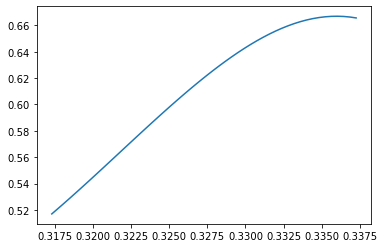

In [286]:
_fids_off_sweep = []
_offs_off_sweep = []
for result in offset_varying_results:
    _fids_off_sweep.append(result["fidelity"])
    _offs_off_sweep.append(result["offset"])

plt.plot(_offs_off_sweep, _fids_off_sweep)
plt.show()
best_offset = offset_varying_results[np.argmax(_fids_off_sweep)]["offset"]
offs_to_test = np.linspace(best_offset-0.01, best_offset+0.01, 50)
offset_varying_results = parfor(vary_offset, offs_to_test)

In [287]:
offset_varying_results[np.argmax(_fids_off_sweep)]

{'fidelity': 0.6015659511350498,
 'offset': 0.3448237476808904,
 'frequency': 7.537725435490236,
 'duration': 50,
 'amplitude': 15.707963267948966}

## Gradient Descent (or at least Simplex)

In [288]:
import scipy

def cost(parameters, constants):
    # parameters = [offset, duration]
    offset = parameters[0]
    duration = parameters[1]
    # constants = [amplitude]
    amplitude = constants[0]
    tlist = np.linspace(0, duration, int(duration*5))
    pulse_gen.setup(amplitude=amplitude, drive_frequency= system.first_energy_spacing/3 - offset, ramp_coef=0.2, tlist=tlist)
    solution = solver.time_evolve(H_d=system.H0, H_c=system.H1, pertubation_func=pulse_gen.pulse_func, tlist=tlist, starting_state=system.basis_states[0], pbar=False)
    expectation_values = expect.get_all_expectation_values(solution.states, system.basis_states)
    fidelity = expectation_values[1][-1]
    return (1-fidelity)

In [323]:
result1 = scipy.optimize.minimize(cost, [0.3448237476808904, 50/2], [2.5*2*np.pi], method="Nelder-Mead", options={"disp":True})

Optimization terminated successfully.
         Current function value: 0.008699
         Iterations: 42
         Function evaluations: 88


In [324]:
result1

 final_simplex: (array([[ 0.30220436, 20.44169987],
       [ 0.30220281, 20.44178075],
       [ 0.30220273, 20.44168127]]), array([0.00869852, 0.00869853, 0.00869853]))
           fun: 0.008698524622060999
       message: 'Optimization terminated successfully.'
          nfev: 88
           nit: 42
        status: 0
       success: True
             x: array([ 0.30220436, 20.44169987])

# Fidelity Landscape

In [331]:
all_results = []

In [332]:
def run_once(dur):
    ramp_coef = 0.2
    tlist = np.linspace(0, dur, int(dur*2))
    pulse_gen.setup(amplitude=_amp, drive_frequency= system.first_energy_spacing/3 - _off, ramp_coef=ramp_coef, tlist=tlist)
    solution = solver.time_evolve(H_d=system.H0, H_c=system.H1, pertubation_func=pulse_gen.pulse_func, tlist=tlist, starting_state=system.basis_states[0], pbar=False)
    expectation_values = expect.get_all_expectation_values(solution.states, system.basis_states)
    return {
        "fidelity": expectation_values[1][-1],
        "offset": _off,
        "frequency":  system.first_energy_spacing/3 - off,
        "duration": dur,
        "amplitude": _amp,
        "ramp_coef": ramp_coef
    }

for off in tqdm(np.linspace(0.1, 0.5, 50)):
    _off = off
    already_did_this_offset = False
    for grouping in all_results:
        for result in grouping:
            if result["offset"] == _off:
                already_did_this_offset = True
                break
    if already_did_this_offset:
        continue

    all_results.append(parallel_map(run_once, np.linspace(1, 200, 50))) # , progress_bar=True

100%|██████████| 50/50 [10:20<00:00, 12.42s/it]


In [86]:
import utils.saver as saver

# saver.save(all_results, "temp_experimental_landscape")
# all_results = saver.load("temp_experimental_landscape")

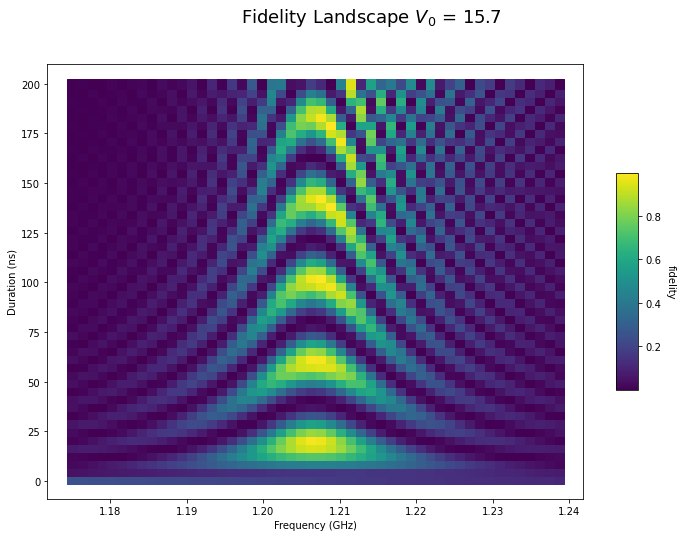

In [333]:
import copy
# %matplotlib widget

amps = []
offs = []
durs = []
fids = []
all_results_to_graph = copy.deepcopy(all_results)
for grouping in all_results_to_graph:
    for result in grouping:
        amps.append(result["amplitude"])
        offs.append(result["offset"])
        durs.append(result["duration"])
        fids.append(result["fidelity"])

fig, axs = plt.subplots(figsize=(12, 8))
fig.suptitle("Fidelity Landscape $V_0$ = %.1f" % amps[-1], fontsize=18)
axs.set_xlabel("Frequency (GHz)")
axs.set_ylabel("Duration (ns)")
freqs = (system.first_energy_spacing/3 - np.array(offs)) / (2*np.pi)
surf = axs.scatter(freqs, durs, c=fids, cmap=None, marker="s", s=100)
cbar = fig.colorbar(surf, shrink=0.5, aspect=10)
cbar.ax.set_ylabel("fidelity", rotation=270)
cbar.ax.get_yaxis().labelpad = 15
# axs.pcolormesh(offs, durs, fids)